In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.cluster.hierarchy as hcluster
import random

In [3]:
batch1 = pd.read_parquet('/opt/app/data/erdos-data/train/batch_1.parquet')
sensor_geom = pd.read_csv('/opt/app/data/erdos-data/sensor_geometry.csv')

In [5]:
def id_to_xyz(sen_id):
    return sensor_geom.loc[sen_id][['x','y','z']].values

In [6]:
batch1.head()
event_list=list(set(batch1.index))
event_index=event_list[0]
event=batch1.loc[event_index]

In [7]:
test = event[['sensor_id', 'time', 'charge']].reset_index()

In [8]:
for i in range(0, len(event)):
    test.loc[i,['x','y','z']] = id_to_xyz(test.loc[i,'sensor_id'])

In [22]:
def cluster_by_event(event, threshhold=150):
    trunc_event=event[['sensor_id', 'charge']]
    raw_data = [np.append(id_to_xyz(trunc_event.iloc[i][0]), trunc_event.iloc[i][1]) for i in range(len(trunc_event))]
    clusters = hcluster.fclusterdata(raw_data, threshhold, criterion='distance')
    return clusters, raw_data

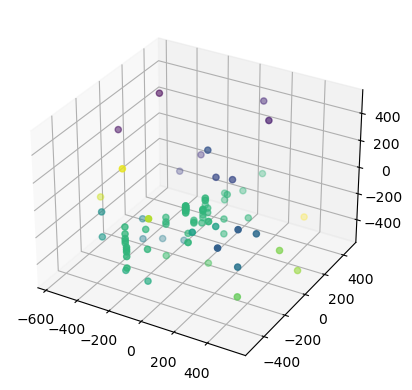

Number of clusters: 27 
 Event_id: 140


In [48]:
#event_id=random.choice(event_list)
event_id=140
event=batch1.loc[140]
clusters, raw_data=cluster_by_event(event,150)
    
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = [a[0] for a in raw_data]
ys = [a[1] for a in raw_data]
zs = [a[2] for a in raw_data]

ax.scatter(xs, ys, zs,
           c=clusters)

plt.show()

print("Number of clusters:", len(set(clusters)),'\n Event_id:', event_id )

event_id
24         False
24         False
24         False
24         False
24         False
           ...  
3266196    False
3266196    False
3266196    False
3266196    False
3266196    False
Name: auxiliary, Length: 32792416, dtype: bool